# Offside

## Introduction, Reference Domain, and Objectives
The Offside project starts from the need of creating a recommendation system based on machine learning which, given a football player, returns a series of players as similar as possible based on a set of technical-tactical data. The reference domain is, obviously, the world of football, and the reference platform for data retrieval is Fbref, a consultation source that includes data relating to players, teams and championships in an easily to consult, -and scrape-, fashion.

The approach that the project intends to adopt is based on a rather simple notion: let's assume we have a two-dimensional Cartesian plane, where each point corresponds to a player based on a pair of technical characteristics of our choice. The players most similar to the original player will be those who have the smallest distance on the Cartesian plane. It is sufficient to raise the plane to n dimensions, one for each of the technical attributes considered, to evaluate the similarity of the players on the hyperplane. The only caveat is that calculating the distance on a n-dimensional plane requires a little bit more effort than doing the same thing for a bi-dimensional plane, but thanks to the use of the Euclidean distance, the problem will be solved quite easily. In the code block that follows, we will begin by importing all the necessary libraries for the model.

In [281]:
# Import necessary libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

## Data Retrieval, Parsing, and Dataframe Construction
This section aims to retrieve data from a Web URL. The specified URL points to a webpage on FBref, a website that, as we mentioned earlier, provides comprehensive football statistics and tables. In particular, the URL variable holds the address of the webpage containing Serie A statistics. The `pd.read_html()` function in the code down below is utilized to parse the HTML content of the webpage and extract tables. However, prior to parsing, the `.replace()` method is employed to remove HTML comment tags ('<!--' and '-->') from the webpage content. This is done to ensure that the HTML can be imported correctly and without hidden elements ruining the formatting, so that it may then be parsed by `read_html()`. This workaround used was found with a quick search on StackOverflow (https://stackoverflow.com/questions/77548912/how-to-extract-table-from-a-webpage-using-its-id)

We then have the `pd.read_html()` function call, inside of which the `requests.get(url).text` retrieves the HTML content of the specified URL, which is then passed to `read_html()` for parsing. The `attrs` parameter is utilized to specify the HTML attribute `id` of the table element that we actually need to be extracted, which in this case is 'stats_standard', a table containing attributes for the players in Serie A. The `[0]` index is appended to the end of the function call to select the first table found on the webpage matching the specified attributes.

In [292]:
import pandas as pd
import requests

# Dizionario degli URL delle leghe
leagues_urls = {
    "SerieA": 'https://fbref.com/en/comps/11/stats/Serie-A-Stats',
    "PremierLeague": 'https://fbref.com/en/comps/9/stats/Premier-League-Stats',
    "Bundesliga": 'https://fbref.com/en/comps/20/stats/Bundesliga-Stats',
    "LaLiga": 'https://fbref.com/en/comps/12/stats/La-Liga-Stats',
    "Ligue1": 'https://fbref.com/en/comps/13/stats/Ligue-1-Stats',
    "Eredivisie": 'https://fbref.com/en/comps/23/stats/Eredivisie-Stats'
}

# Inizializzazione del DataFrame vuoto
dfs = []

# Iterazione attraverso il dizionario degli URL delle leghe
for league, url in leagues_urls.items(): 
    if 'league_filter' in locals() and league not in league_filter:
        continue  # Skip if the league is not in the league_filter list
    # Utilizzo della libreria pandas per leggere il contenuto HTML dall'URL specificato
    # Sostituzione dei commenti HTML per garantire il corretto parsing del contenuto
    # Estrazione della tabella dei dati con gli attributi specificati
    df = pd.read_html(
        requests.get(url).text.replace('<!--','').replace('-->','')
        ,attrs={'id':'stats_standard'}
    )[0]

    # Definizione dei nuovi nomi delle colonne da utilizzare per il DataFrame
    new_columns = [
        "(Background Information, Alphabetical Rank)",
        "(Background Information, Full Name)",
        "(Background Information, Nation)",
        "(Background Information, Position)",
        "(Background Information, Squad)",
        "(Background Information, Age)",
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ] + list(df.columns[36:])  

    # Assegnazione dei nuovi nomi delle colonne al DataFrame
    df.columns = new_columns

    # Conversione di colonne specifiche ai tipi di dati appropriati
    df["(Background Information, Full Name)"] = df["(Background Information, Full Name)"].astype("string")
    df["(Background Information, Position)"] = df["(Background Information, Position)"].astype("category")
    df["(Background Information, Squad)"] = df["(Background Information, Squad)"].astype("category")

    # Lista delle colonne numeriche da convertire al tipo numerico
    numerical_columns_to_convert = [
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ]

    # Conversione delle colonne specificate al tipo di dato numerico
    for col in numerical_columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Rimozione delle colonne non necessarie dal DataFrame
    df.drop('(Background Information, Alphabetical Rank)', axis=1, inplace=True)
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    # Aggiunta della colonna della lega al DataFrame
    df["(Background Information, League)"] = league

    # Aggiunta del DataFrame al DataFrame iniziale
    dfs.append(df)

# Concatenazione dei DataFrame ottenuti da tutte le leghe
df = pd.concat(dfs, ignore_index=True)

# Esportazione del DataFrame elaborato in un file CSV
df.to_csv("all_leagues.csv", encoding='utf-8', index=False)

# Restituzione del DataFrame modificato
df


,"(Background Information, Full Name)","(Background Information, Nation)","(Background Information, Position)","(Background Information, Squad)","(Background Information, Age)","(Background Information, Year of Birth)","(Playing Time, MP)","(Playing Time, Starts)","(Playing Time, Min)","(Playing Time, 90s)",...,"(Per 90 Minutes, Ast)","(Per 90 Minutes, G+A)","(Per 90 Minutes, G-PK)","(Per 90 Minutes, G+A-PK)","(Per 90 Minutes, xG)","(Per 90 Minutes, xAG)","(Per 90 Minutes, xG+xAG)","(Per 90 Minutes, npxG)","(Per 90 Minutes, npxG+xAG)","(Background Information, League)"
0,Tammy Abraham,eng ENG,FW,Roma,25,1997.0,8.0,2.0,242.0,2.7,...,0.00,0.37,0.37,0.37,0.22,0.05,0.27,0.22,0.27,SerieA
1,Francesco Acerbi,it ITA,DF,Inter,35,1988.0,29.0,26.0,2388.0,26.5,...,0.04,0.15,0.11,0.15,0.06,0.07,0.13,0.06,0.13,SerieA
2,Yacine Adli,fr FRA,MF,Milan,23,2000.0,24.0,17.0,1407.0,15.6,...,0.13,0.19,0.06,0.19,0.02,0.14,0.16,0.02,0.16,SerieA
3,Michel Aebischer,ch SUI,MF,Bologna,26,1997.0,36.0,26.0,2230.0,24.8,...,0.04,0.04,0.00,0.04,0.04,0.06,0.11,0.04,0.11,SerieA
4,Lucien Agoume,fr FRA,MF,Inter,21,2002.0,1.0,0.0,5.0,0.1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,SerieA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3506,Lequincio Zeefuik,nl NED,"FW,MF",Volendam,18,2004.0,16.0,8.0,773.0,8.6,...,0.12,0.47,0.35,0.47,0.23,0.11,0.33,0.23,0.33,Eredivisie
3507,Ramiz Zerrouki,dz ALG,MF,Feyenoord,25,1998.0,26.0,15.0,1387.0,15.4,...,0.00,0.00,0.00,0.00,0.02,0.12,0.14,0.02,0.14,Eredivisie
3508,Giovanni van Zwam,nl NED,DF,Vitesse,19,2004.0,12.0,3.0,492.0,5.5,...,0.00,0.00,0.00,0.00,0.05,0.01,0.05,0.05,0.05,Eredivisie
3509,Willum Þór Willumsson,is ISL,MF,Go Ahead Eag,24,1998.0,31.0,31.0,2672.0,29.7,...,0.07,0.30,0.24,0.30,0.18,0.13,0.32,0.18,0.32,Eredivisie


## Data Preparation, Cleaning, and Optimization

After scraping the data, we need to prepare it for further analysis and processing. First of all, the column names are re-defined to enhance clarity and comprehension of the dataset. These new column names are structured hierarchically in order to categorize various aspects of player information, performance metrics, and expected outcomes. After the renaming process, the data types of some specific columns are adjusted to ensure consistency and suitability for analysis. Columns containing strings are converted to the string data type, while categorical columns are converted to categorical data type for efficient storage and computation. Additionally, columns representing numerical data are converted to numeric type, with appropriate error handling to manage any inconsistencies or invalid entries. As the model will be based on the computation of the n-Dimensional Euclidean Distance (where n is the amount of attributes considered), we will need several numerical values in order to make a model that is precise and consistent.

Furthermore, unnecessary information is removed from the dataset to streamline its structure and optimize the analytical processes. Columns such as alphabetical rank and nationality are deemed irrelevant for the intended analysis, as they do not contribute significantly to player comparisons or performance evaluations. In the same way, redundancies are removed: we already have the year of birth of a player, so the age attribute is irrelevant and essentially duplicate information. Additionally, a redundant hyperlink column (in particular, the last column, provided by Fbref as a Hyperlink to another page) is eliminated. Finally, the processed dataset is exported to a CSV file named "serieA.csv" to facilitate future analysis and sharing. What follows is a description of the columns of the dataset as provided by the website.

### Dataset Columns Explanation

#### Background Information
1. **(Background Information, Alphabetical Rank)**: represents the alphabetical ranking of the players *[REDACTED]*
2. **(Background Information, Full Name)**: indicates the full name of the player
3. **(Background Information, Nation)**: specifies the nationality of the player *[REDACTED]*
4. **(Background Information, Position)**: specifies the primary position of the player
5. **(Background Information, Squad)**: denotes the squad the player belongs to
6. **(Background Information, Age)**: represents the age of the player *[REDACTED]*
7. **(Background Information, Year of Birth)**: indicates the year of birth of the player

#### Playing Time
8. **(Playing Time, MP)**: stands for Matches Played.
9. **(Playing Time, Starts)**: denotes the number of matches started by the player
10. **(Playing Time, Min)**: represents the total minutes played by the player
11. **(Playing Time, 90s)**: indicates the total minutes played divided by 90

#### Performance
12. **(Performance, Gls)**: represents the number of goals scored by the player
13. **(Performance, Ast)**: denotes the number of assists made by the player
14. **(Performance, G+A)**: indicates the total number of goals and assists combined
15. **(Performance, G-PK)**: represents the number of goals scored excluding penalty kicks
16. **(Performance, PK)**: denotes the number of penalty kicks scored by the player
17. **(Performance, PKatt)**: represents the number of penalty kicks attempted by the player
18. **(Performance, CrdY)**: indicates the number of yellow cards received by the player
19. **(Performance, CrdR)**: denotes the number of red cards received by the player

#### Expected
20. **(Expected, xG)**: represents the expected goals for the player
21. **(Expected, npxG)**: denotes the non-penalty expected goals for the player
22. **(Expected, xAG)**: represents the expected assists for the player
23. **(Expected, npxG+xAG)**: indicates the sum of non-penalty expected goals and expected assists

#### Progression
24. **(Progression, PrgC)**: stands for progressive carries made by the player
25. **(Progression, PrgP)**: denotes progressive passes made by the player
26. **(Progression, PrgR)**: represents progressive carries made by the player

#### Per 90 Minutes
27. **(Per 90 Minutes, Gls)**: represents the average number of goals scored per 90 minutes
28. **(Per 90 Minutes, Ast)**: denotes the average number of assists made per 90 minutes
29. **(Per 90 Minutes, G+A)**: indicates the average number of goals and assists combined per 90 minutes
30. **(Per 90 Minutes, G-PK)**: represents the average number of goals scored excluding penalty kicks per 90 minutes
31. **(Per 90 Minutes, G+A-PK)**: denotes the average number of goals and assists combined excluding penalty kicks per 90 minutes
32. **(Per 90 Minutes, xG)**: represents the average expected goals per 90 minutes
33. **(Per 90 Minutes, xAG)**: denotes the average expected assists per 90 minutes
34. **(Per 90 Minutes, xG+xAG)**: indicates the average sum of expected goals and expected assists per 90 minutes
35. **(Per 90 Minutes, npxG)**: represents the average non-penalty expected goals per 90 minutes
36. **(Per 90 Minutes, npxG+xAG)**: denotes the average sum of non-penalty expected goals and expected assists per 90 minutes
37. **(Hyperlink Column)**: shows a hyperlink to another page of the website *[REDACTED]*

These columns collectively provide a comprehensive overview of player performance, background, and progression metrics, facilitating in-depth analysis and insights as the further progression of the model will demonstrate.


In [293]:
#REDACTED

## Parametric Configuration, Algorithmic Definition, and Data Modelling

The following block of code is dedicated to the configuration of the model, which was designed to be as modular as possible in order to be reused according to the individual needs of sports data analysis professionals. In particular, the code first allows us to specify the name and surname of the player we intend to take as a reference. Simply pass a string to the code containing the name of the player contained in the Column `(Background Information, Full Name)`, for example `reference_player_name = "Francesco Acerbi"`. Obviously, the player must be present in the Table, otherwise an error will be thrown. We then have a role filter, called `role_filter`. If this variable is set to `None`, then no filter will be used and the search will take place taking the players' statistical differences as a guideline. If, however, we have a specific position in mind for which to scout a player, for example the goalkeeper, just write `role_filter = "GK"`, and all the players returned will be players with `"GK"` as the value of their `(Background Information, Position)` column. This can be particularly useful when the starting point of the search is a goalkeeper with good feet (i.e. Mike Maignan), who due to his high ability to generate assists, without the filter activated could be compared with defenders or midfielders

We then have the variable `number_of_players_returned`, which indicates the quantity of players that will be returned by the algorithm. By default, this parameter is set to 5, but you can change it to have a longer list of similarities. It goes without saying that the longer the list, the less similar the values at the bottom of the list are to the original player. Finally we have the `relevant_cols` Array, which contains a list chosen by the analyst of the attributes to be included in the Euclidean comparison of the players. The columns to be inserted must have the same name as the corresponding columns on the dataframe, paying careful attention to Case Sensitivity: uppercase and lowercase are treated differently, and this could cause errors. By default, the vast majority of the columns present have been selected, as this allows for an all-round analysis of the players and their respective comparisons between them. However, it is possible to remove or add values (simply by commenting the respective line) based on scouting needs

In [294]:
"""
-* MODEL CONFIGURATION *-
The following block of code contains the configuration parameters of the model, designed for modularity in sports data analysis. 
It enables customization according to individual needs, so please follow this explanation of the editable values in order to make the best out of it.

1. reference_player_name: identifies the player to be brought up for comparison.
   Please provide the full name as listed in the dataset under the (Background Information, Full Name) column.

2. role_filter: specifies the positional filter. 
   If set to None, the algorithm compares players based on statistical differences. 
   If set to a specific role abbreviation, the search is narrowed down to players with the same position.
   Useful for focused searches, ensuring relevant comparisons.
   Definitions of player roles:
   None - No Filter Active 
   "GK" - Goalkeepers
   "DF" - Defenders
   "MF" - Midfielders
   "FW" - Forwards
   "FB" - Fullbacks
   "LB" - Left Backs
   "RB" - Right Backs
   "CB" - Center Backs
   "DM" - Defensive Midfielders
   "CM" - Central Midfielders
   "LM" - Left Midfielders
   "RM" - Right Midfielders
   "WM" - Wide Midfielders
   "LW" - Left Wingers
   "RW" - Right Wingers
   "AM" - Attacking Midfielders

3. number_of_players_returned: indicates the quantity of players returned by the algorithm.
   Default is set to 5 for concise output, but can be adjusted for more comprehensive lists.
   Note: Increasing the number may reduce similarity among listed players along the bottom of the list.
   
4. relevant_cols: contains the columns of the dataframe that are to be taken in consideration by the algorithm.
   A sensible default value has already been set, but can be adjusted if other scouting needs need to be met.
   
5. league_filter: this parameter is designed to refine player comparisons based on their performance in specific leagues.
    It allows users to specify one or more leagues from which player data will be considered for analysis.
    By setting league_filter to a list of league abbreviations, users can narrow down the comparison to players who have 
    participated in the specified leagues. This ensures that the analysis is tailored to the context of particular 
    football competitions, facilitating more relevant player assessments.

    Supported Leagues:
    - SerieA: Italian Serie A
    - PremierLeague: English Premier League
    - Bundesliga: German Bundesliga
    - LaLiga: Spanish La Liga
    - Ligue1: French Ligue 1
    - Eredivisie: Dutch Eredivisie
    
"""

# Set your desired reference player's name
reference_player_name = "Olivier Giroud"

# Set your desired role filter
role_filter = None

# Set your desired number of players to be returned 
number_of_players_returned = 5

# Set your desired relevant columns
relevant_cols = ["(Background Information, Position)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"]

# Set your desired league filter
league_filter = ["SerieA", "PremierLeague", "Bundesliga", "LaLiga", "Ligue1", "Eredivisie"]

After the data preparation and the configuration phase, we can finally enter the modelling phase. The data pre-processing begins with the removal of any rows containing missing values (`NaN`) from the DataFrame containing the football player data, as this will avoid potential errors down the line. Relevant columns (`relevant_cols`) are then selected in order to describe various aspects of the player such as background information, playing time, performance metrics, expected goals, progression, and statistics per 90 minutes. In order to facilitate the normalization process, only the numeric columns are retained from the array of containing the relevant columns. The data is then normalized for each column, in order to create a fairer distribution and result in the evaluation phase.

The real insight behind the construction of the Model is the idea of mapping football players in an n-dimensional plane, based on their statistics and technical characteristics. To do this, we use the Euclidean distance formula, which is applicable to vectors of any size. Instead of implementing it manually, we will use the SciPy `euclidean` Function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html), which we have already imported previously with `from scipy .spatial.distance import euclidean`. This formula can be used to calculate the distance between two points in n-dimensional space, and in our example it fits perfectly to the size of the vectors involved. So, whether the vectors are two-dimensional, three-dimensional or higher dimensional, the formula remains the same, and this allows us to reason at an n-dimensional level as we would have done at a two-dimensional level: neighboring points in space equal players with similar characteristics. For completeness, here is the Euclidean Formula used, where `u` and `v` are two vectors of dimension `n`

$$\text{euclidean}(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^{n} (u_i - v_i)^2}$$

The code will compute the Euclidean distances between the provided reference player and all other players in the dataset, filtering by role if specified. The distances are stored in a dictionary where the keys represent player indices and the values represent their respective distances from the reference player. These distances are then sorted in ascending order. The players most similar to the reference player are extracted based on their ascending Euclidean distances, defined as `Delta` in the printed summary, to represent a numerical indicator of distance between the reference player and another player (the lower the delta value, the better the similarity). Finally, the results are printed, formatted for having good readability and insights. If a role filter is applied, a note is provided regarding its influence on the returned results, to avoid potential oversights. It is also good to mention the speed of execution. The Euclidean Distance using the following code can be calculated in `O(n)` time, where `n` is the dimension of the input vectors. This is because the calculation involves only sums, multiplications, and square roots, which can be performed in linear time with respect to the size of the vectors. Therefore, we can also decide to have a huge list of players returned to us, and everything will be calculated in a matter of milliseconds.

In [295]:
# A Class defining attribute for text styling and formatting improvements
class text_style:
   BOLD = '\033[1m' 
   UNDERLINE = '\033[4m' 
   END = '\033[0m' 

# Dropping rows with missing values to avoid errors
df.dropna(inplace=True)

# Select numeric columns
numeric_cols = df[relevant_cols].select_dtypes(include=['number'])

# Normalize the data
normalized_df = (numeric_cols - numeric_cols.mean()) / numeric_cols.std()

# Find the index of the row corresponding to the reference player
reference_player_index = df.index[df['(Background Information, Full Name)'] == reference_player_name][0]

# Calculate distances between the reference player and others
distances = {}
reference_player = normalized_df.loc[reference_player_index]

for i, player in normalized_df.iterrows():
    if i == reference_player_index:
        continue
    # Add role filtering condition
    if role_filter is not None and df.loc[i]['(Background Information, Position)'] != role_filter:
        continue
    # Add league filtering condition
    if df.loc[i]['(Background Information, League)'] not in league_filter:
        continue
    distances[i] = euclidean(reference_player, player)

# Sort distances
sorted_distances = sorted(distances.items(), key=lambda x: x[1])

# Select top similar players
top_similar_players = sorted_distances[:number_of_players_returned]

# Print header
print(text_style.BOLD + f"The reference player is {reference_player_name}\n"
      f"Below is a list of the players most similar to the player mentioned above,\n"
      f"ordered from most to least similar via Euclidean distance sampling.\n" + text_style.END)
index_number = 1

# Print role filter information
if role_filter is not None:
    print(text_style.BOLD + f"Please note that the values returned by the model are filtered for the '{role_filter}' role. "
                            f"\nYou can change or remove the filter entirely in the algorithm configuration section at any time.\n" + text_style.END)
else:
    print(text_style.BOLD + "Please note that the values returned by the model are not filtered by any role. "
                            "\nYou can add or change the role filter in the algorithm configuration section at any time.\n"  + text_style.END)
      
print('─' * 25)
print()

# Print details of top similar players
for player_index, distance in top_similar_players:
    player_name = df.loc[player_index]['(Background Information, Full Name)']
    player_role = df.loc[player_index]['(Background Information, Position)']
    player_club = df.loc[player_index]['(Background Information, Squad)']
    player_age = df.loc[player_index]['(Background Information, Year of Birth)']
    
    print(text_style.BOLD + f"Player #{index_number}: {player_name + text_style.END}\nRole: {player_role}\nTeam: {player_club}\nBorn In: {'{:.0f}'.format(player_age)}\nDelta: {'{:.5f}'.format(distance)}\n")
    
    index_number += 1

The reference player is Olivier Giroud
Below is a list of the players most similar to the player mentioned above,
ordered from most to least similar via Euclidean distance sampling.

Please note that the values returned by the model are not filtered by any role. 
You can add or change the role filter in the algorithm configuration section at any time.

─────────────────────────

Player #1: Niclas Füllkrug
Role: FW
Team: Dortmund
Born In: 1993
Delta: 4.81078

Player #2: Antoine Griezmann
Role: FW,MF
Team: Atlético Madrid
Born In: 1991
Delta: 4.85468

Player #3: Victor Osimhen
Role: FW
Team: Napoli
Born In: 1998
Delta: 5.01267

Player #4: Tobias Lauritsen
Role: FW
Team: Sparta R'dam
Born In: 1997
Delta: 5.19242

Player #5: Robert Lewandowski
Role: FW
Team: Barcelona
Born In: 1988
Delta: 5.26614


## Data Visualisation and Plotting


To better understand the results obtained, we will exploit two different plotting techniques, the first will be a classic Horizontal Bar Plot, while the second will be a Radar Plot. Starting with the Bar Plot contained in the following code, this rather simple and intuitive to understand graph shows the results of the distance of the `n` players most similar to the player taken as reference. The x-axis of the graph shows the Delta, i.e. the distance coefficient between the reference player and the players most similar to him. The lower the value, the better the similarity between the two. The y-axis shows the name of the players, ordered from most to least similar to the player who gives the title to the table (in other words, the players are presented in ascending order based on the value of Delta). The color of the bars corresponding to the players displayed in the graph will be useful to visualize at a glance the team to which they belong, as shown in the legend. The primary purpose of this graph is to give a quick and shareable visualization of the result obtained by the algorithm, useful as a clarifying example for non-technical personnel who may need to use the information produced. However, this is not the most in-depth way of analyzing the differences, which is why it will not be the only view adopted.

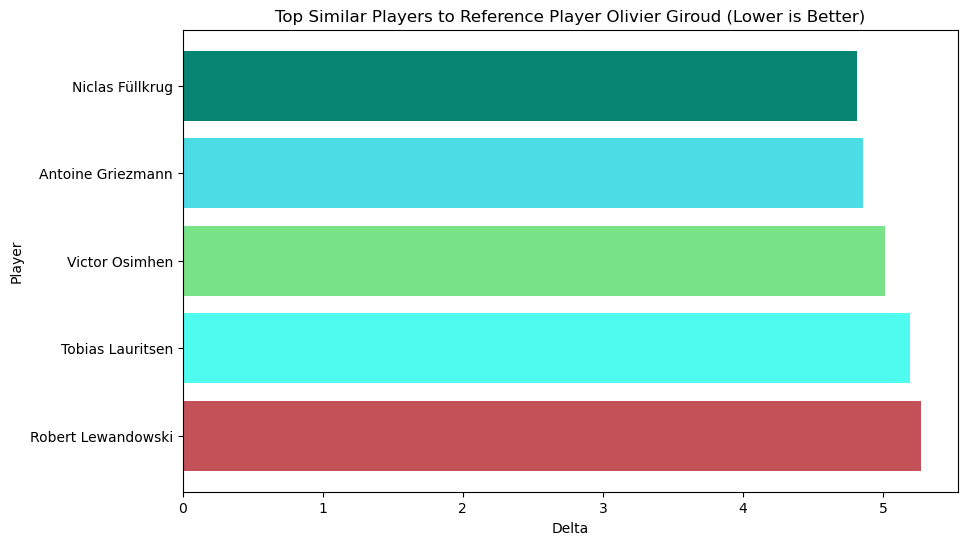

In [296]:
import random

# Extracting player names and distances
similar_player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
similar_player_distances = [distance for _, distance in top_similar_players]

# Assigning random colors to players
player_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in similar_player_names]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(similar_player_names, similar_player_distances, color=player_colors)

# Labeling axes and title
plt.xlabel('Delta')
plt.ylabel('Player')
plt.title(f'Top Similar Players to Reference Player {reference_player_name} (Lower is Better)')

# Inverting y-axis to display players with the highest similarity at the top
plt.gca().invert_yaxis()  

# Displaying the plot
plt.show()


The real complication arising from plotting data beyond three dimensions comes from finding a compromise between making the data as comprehensible as possible, without at the same time giving up the depth and insights they offer. After an analysis of the graphs that can be created with Python (an excellent reference material in this regard is the Python Graph Gallery, that can be found at this URL: https://python-graph-gallery.com), it was clear that the best choice for the problem at hand was the Radar Plot, also known as Spider Plot or Polar Chart. The Plot contained in the following code block was created using MatPlotLib (the documentation used to build the next code block can be found on https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html, and scattered around StackOverflow Threads and Online Forums), through the creation of the `radar_plot` function. This function takes as input several parameters `player_names`, `player_data`, `reference_data`, `attribute_labels`, and `reference_player_name`. Using the values contained in them, it constructs an informative display, complete with legend. This is by far the most useful graph, as it allows you to observe multivariate data in a clear and efficient way, allowing easy comparison of players based on their attributes. 

The way the Calculation Model is structured generates an interesting graphical phenomenon. As long as you keep the list of suggested players within responsible limits, the plotting creates a clear silhouette of their areas of excellence, -or lack-. Since the model calculates the delta via Euclidean distance, the resulting plots are denoted by a similar shape and distribution within the radar space. Furthermore, such a visualization allows you to focus at a glance on attributes that may be more interesting than others. For example, you can focus on the number of assists you expect, find the player who has the most playing time, or even find the player most capable of scoring goals; and in the list of proposed players find the one who is considered best in that aspect. In this way, the graph not only highlights the actual similarity of the players compared to the reference player, but also proves to be a valuable tool in moments when it is necessary to make an informed decision based on the available data.

In [301]:
import pandas as pd

# Funzione per esportare i dati del confronto in un file CSV
def export_comparison_csv(player_names, player_data, attribute_labels, reference_player_name, df):
    # Lista di tutti gli attributi nel loro ordine desiderato
    all_attributes = [
        "(Background Information, Squad)",
        "(Background Information, League)",
        "(Background Information, Position)",
        "(Background Information, Nation)",
        "(Background Information, Age)",
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ]
    
    # Estrazione dei dati originali dei giocatori dal DataFrame df
    player_indices = [df[df['(Background Information, Full Name)'] == player_name].index[0] for player_name in player_names]
    player_data_original = [df.loc[player_index][all_attributes] for player_index in player_indices]

    # Creazione del DataFrame con i dati dei giocatori
    comparison_data = pd.DataFrame(player_data_original, columns=all_attributes)
    
    # Creazione della lista temporanea per i nomi dei giocatori con il suffisso "(Riferimento)"
    modified_player_names = [f"{player_names[0]} (Riferimento)"] + player_names[1:]
    
    # Aggiunta dei nomi dei giocatori come colonna
    comparison_data.insert(0, 'Player Name', modified_player_names)
    
    # Esportazione in un file CSV
    file_name = f"./Exports/Comparisons/Confronto_{reference_player_name}.csv"
    comparison_data.to_csv(file_name, index=False)
    print(f"I dati del confronto sono stati esportati in '{file_name}'.")

# Chiamata alla funzione per esportare i dati
export_comparison_csv(player_names, player_data, attribute_labels, reference_player_name, df)


I dati del confronto sono stati esportati in './Exports/Comparisons/Confronto_Olivier Giroud.csv'.


In [288]:
import pandas as pd

# Funzione per arrotondare gli attributi desiderati
def round_player_data(data):
    # Attributi da arrotondare
    attributes_to_round = [
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)", "(Playing Time, Starts)", "(Playing Time, Min)",
        "(Performance, Gls)", "(Performance, Ast)", "(Performance, G+A)",
        "(Performance, G-PK)", "(Performance, PK)", "(Performance, PKatt)",
        "(Performance, CrdY)", "(Performance, CrdR)", "(Progression, PrgC)",
        "(Progression, PrgP)", "(Progression, PrgR)"
    ]
    
    # Arrotonda gli attributi desiderati
    for attribute in attributes_to_round:
        if attribute in data.columns:
            data[attribute] = data[attribute].round()
    
    return data

# Funzione per esportare i dati del confronto in un file CSV
def export_comparison_csv(player_names, player_data, attribute_labels, reference_player_name, df):
    # Attributi aggiuntivi da includere nella tabella
    additional_attributes = [
        "(Background Information, Squad)",
        "(Background Information, League)",
        "(Background Information, Position)",
        "(Background Information, Nation)",
        "(Background Information, Age)",
        "(Background Information, Year of Birth)"
    ]
    
    # Combina gli attributi originali con quelli aggiuntivi
    all_attributes = additional_attributes + attribute_labels
    
    # Estrazione dei dati originali dei giocatori dal DataFrame df
    player_indices = [df[df['(Background Information, Full Name)'] == player_name].index[0] for player_name in player_names]
    player_data_original = [df.loc[player_index][all_attributes] for player_index in player_indices]

    # Creazione del DataFrame con i dati dei giocatori
    comparison_data = pd.DataFrame(player_data_original, columns=all_attributes)
    
    # Arrotondamento dei dati dei giocatori
    comparison_data = round_player_data(comparison_data)
    
    # Creazione della lista temporanea per i nomi dei giocatori con il suffisso "(Riferimento)"
    modified_player_names = [f"{player_names[0]} (Reference)"] + player_names[1:]
    
    # Aggiunta dei nomi dei giocatori come colonna
    comparison_data.insert(0, 'Player Name', modified_player_names)
    
    # Esportazione in un file CSV
    file_name = f"Comparison [{reference_player_name}].csv"
    comparison_data.to_csv(file_name, index=False)
    print(f"I dati del confronto sono stati esportati in '{file_name}'.")

# Chiamata alla funzione per esportare i dati
export_comparison_csv(player_names, player_data, attribute_labels, reference_player_name, df)


I dati del confronto sono stati esportati in 'Comparison [Olivier Giroud].csv'.


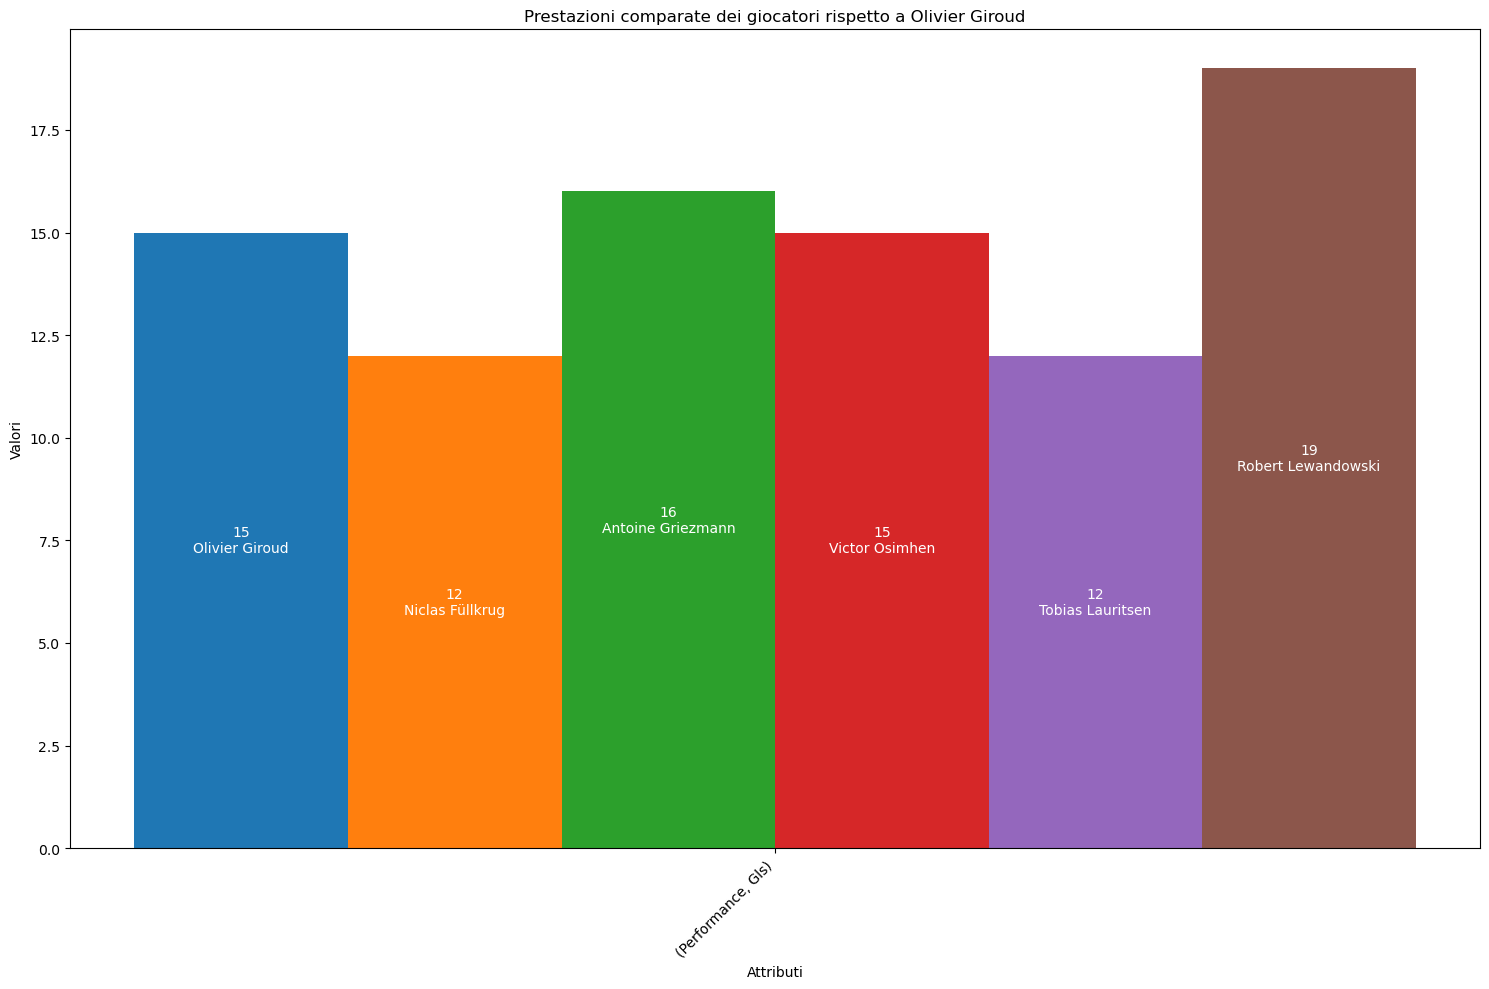

In [270]:
 import matplotlib.pyplot as plt
import numpy as np

# Lista delle colonne rilevanti
relevant_cols = ["(Performance, Gls)"]

# Funzione per creare un grafico a barre
def bar_plot(player_names, player_data, attribute_labels, reference_player_name):
    num_players = len(player_names)
    num_attributes = len(attribute_labels)
    
    # Creazione della figura
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Impostazione della larghezza delle barre
    bar_width = 0.8 / num_players
    
    # Creazione delle barre per ogni giocatore
    for i, player in enumerate(player_names):
        positions = np.arange(num_attributes) + i * bar_width
        bars = ax.bar(positions, player_data[i], bar_width, label=player)
        
        # Aggiunta del numero dei goal e del nome del giocatore all'interno di ogni barra
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}\n{player}',
                        xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                        xytext=(0, 0),  # No offset
                        textcoords="offset points",
                        ha='center', va='center', color='white', fontsize=10, rotation=0)
    
    # Impostazione delle etichette degli assi
    ax.set_xticks(np.arange(num_attributes) + bar_width * (num_players - 1) / 2)
    ax.set_xticklabels(attribute_labels, rotation=45, ha='right')
    
    # Rimozione della legenda
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Aggiunta delle etichette degli assi
    ax.set_xlabel('Attributi')
    ax.set_ylabel('Valori')
    ax.set_title(f'Prestazioni comparate dei giocatori rispetto a {reference_player_name}')
    
    # Visualizzazione del grafico
    plt.tight_layout()
    plt.show()

# Estrazione dei nomi dei giocatori e dei dati per il grafico
player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
player_data = [df.loc[player_index][relevant_cols].values for player_index, _ in top_similar_players]

# Estrazione dell'indice del giocatore di riferimento e dei suoi dati
reference_player_index = df[df['(Background Information, Full Name)'] == reference_player_name].index[0]
reference_data = df.loc[reference_player_index][relevant_cols].values

# Inserimento del nome e dei dati del giocatore di riferimento all'inizio delle liste
player_names.insert(0, reference_player_name)
player_data.insert(0, reference_data)

# Impostazione delle etichette degli attributi
attribute_labels = relevant_cols

# Generazione del grafico a barre
bar_plot(player_names, player_data, attribute_labels, reference_player_name)


## In Conclusion

The Offside project was born with the idea of developing a solid, modular and efficient recommendation system, trying to offer personalized suggestions on football players based on the analysis and modeling of a constantly updated set of technical-tactical data. By exploiting a multidimensional approach based on the use of the expansion of a Cartesian plane and Euclidean distances, the project aimed to identify football players with the best similarity to a player taken as a reference.

Central to the project was the idea of building an algorithm from scratch that was capable of exploiting Euclidean distance calculations to quantify player similarities in an n-dimensional space. The resulting model was able to compute the required similarities, doing so with high computational efficiency, and minimizing the time investments required to use the model in practice. Not only this, but the model also presents great modularity: a professional in the analytical sector can easily modify its parameters to obtain a personalized and satisfactory result based on his needs.

Everything is completed by the visualization aspect, which provides intuitive representations that can be used not only by an analyst, but also by non-technical personnel, who can thus easily understand the insights deriving from the model. By mixing data-driven methodologies, a little creativity and machine learning, the project succeeded in its aim of building a framework capable of facilitating informed decision-making, optimizing player selection strategies in the dynamic world of football.